<a href="https://colab.research.google.com/github/ramyanna12/DL-lowperformanace-system/blob/main/Copy_of_Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [2]:
# Path to the dataset on Google Drive
dataset_path = '/content/drive/MyDrive/archive/'



In [3]:
# Import necessary libraries
import numpy as np
import os
import struct



In [4]:
# Define a function to load Fashion-MNIST dataset
def load_fashion_mnist(path):
    train_images_path = os.path.join(path, 'train-images-idx3-ubyte')
    train_labels_path = os.path.join(path, 'train-labels-idx1-ubyte')
    test_images_path = os.path.join(path, 't10k-images-idx3-ubyte')
    test_labels_path = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Load training images
    with open(train_images_path, 'rb') as f:
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        train_images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)

    # Load training labels
    with open(train_labels_path, 'rb') as f:
        _, num_labels = struct.unpack('>II', f.read(8))
        train_labels = np.fromfile(f, dtype=np.uint8)

    # Load test images
    with open(test_images_path, 'rb') as f:
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        test_images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)

    # Load test labels
    with open(test_labels_path, 'rb') as f:
        _, num_labels = struct.unpack('>II', f.read(8))
        test_labels = np.fromfile(f, dtype=np.uint8)

    return train_images, train_labels, test_images, test_labels



In [5]:
# Load the Fashion-MNIST dataset
train_images, train_labels, test_images, test_labels = load_fashion_mnist(dataset_path)

# Print dataset information
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


In [7]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x



In [8]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create custom Dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create train and test datasets
train_dataset = FashionMNISTDataset(train_images, train_labels, transform)
test_dataset = FashionMNISTDataset(test_images, test_labels, transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FashionMNISTModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

print("Training finished.")


Epoch [1/10], Loss: 0.3438149392604828
Epoch [2/10], Loss: 0.21397867798805237
Epoch [3/10], Loss: 0.13383840024471283
Epoch [4/10], Loss: 0.1882704794406891
Epoch [5/10], Loss: 0.24411483108997345
Epoch [6/10], Loss: 0.2000441998243332
Epoch [7/10], Loss: 0.11428238451480865
Epoch [8/10], Loss: 0.0706583708524704
Epoch [9/10], Loss: 0.06478814780712128
Epoch [10/10], Loss: 0.04988764971494675
Training finished.


In [10]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.5 MB/s eta 0:00:00


In [11]:
import torch
from captum.attr import LayerGradCam
from torchvision.utils import make_grid

# Choose a random image from the test set
random_index = torch.randint(0, len(test_dataset), (1,))
image, label = test_dataset[random_index]
image = image.unsqueeze(0).to(device)




In [12]:
# Create a LayerGradCam instance
layer_name = model.conv1  # Replace 'model.conv1' with the actual layer object from your model
layer_grad_cam = LayerGradCam(model, layer_name)

# Compute the attribution using Grad-CAM
attributions = layer_grad_cam.attribute(image, target=torch.tensor(label).unsqueeze(0).to(device))

# Convert the tensor image and attributions to numpy arrays
image_np = image.squeeze().cpu().numpy()
attributions_np = attributions.squeeze().detach().cpu().numpy()

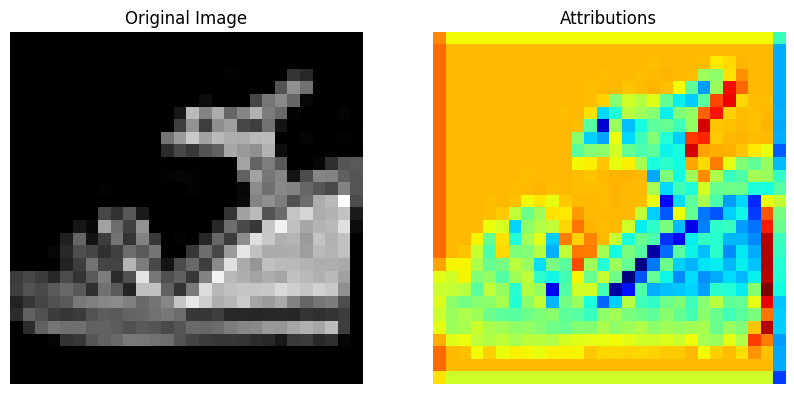

In [13]:
# Plot the original image and its attributions
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_np, cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")
axs[1].imshow(attributions_np, cmap="jet")
axs[1].set_title("Attributions")
axs[1].axis("off")

plt.show()

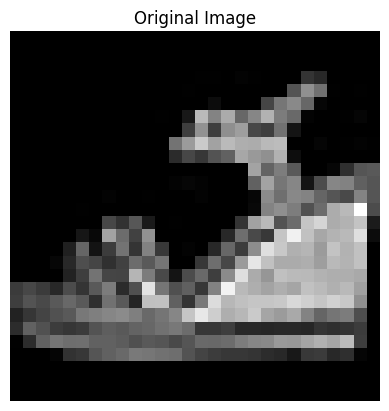

Predicted Class: 5


In [14]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import functional as TF

# Remove the extra dimension from the image tensor
image = image.squeeze()

# Convert the image tensor to a NumPy array
image_np = image.detach().cpu().numpy()

# Reshape the image array to (28, 28)
image_np = image_np.reshape(28, 28)

# Display the original image
plt.imshow(image_np, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.show()

# Reshape the image tensor for resizing
image_reshaped = image.view(1, 1, 28, 28)

# Resize the image to match the expected input size of the model
resized_image = F.interpolate(image_reshaped, size=(28, 28))

# Get the predicted class label
predicted_label = model(resized_image.to(device)).argmax().item()

# Display the predicted class label
print('Predicted Class:', predicted_label)


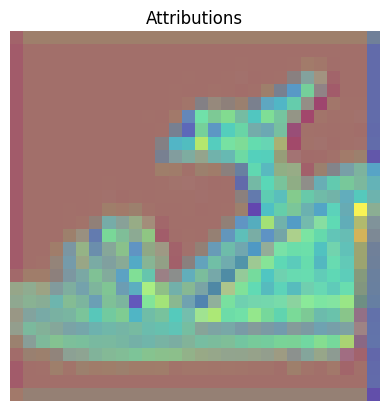

In [15]:
import matplotlib.pyplot as plt

# Display the attributions
plt.imshow(attributions_np, cmap='jet', alpha=0.5)
plt.imshow(image_np, alpha=0.5)
plt.axis('off')
plt.title('Attributions')
plt.show()


In [16]:
import numpy as np

def analyze_xai_results(attributions_np):
    # Calculate the average attribution score for each pixel
    avg_attributions = np.mean(attributions_np, axis=0)

    # Identify the pixels with the highest average attribution scores
    top_pixels = np.argsort(avg_attributions)[::-1][:10]

    # Print the top pixels with their corresponding average attribution scores
    print("Top Pixels:")
    for pixel in top_pixels:
        print(f"Pixel {pixel}: Average Attribution = {avg_attributions[pixel]}")

    # Visualize the attributions
    plt.imshow(attributions_np, cmap='jet')
    plt.title('Attributions')
    plt.colorbar()
    plt.show()

    # Additional analysis and visualization code can be added here

    # Return any relevant insights or analysis results
    return avg_attributions, top_pixels


In [17]:
# Choose a random image from the test set
random_index = torch.randint(0, len(test_dataset), (1,))
image, label = test_dataset[random_index]
image = image.unsqueeze(0).to(device)


# Create a LayerGradCam instance
layer_name = model.conv2  # Replace 'model.conv1' with the actual layer object from your model
layer_grad_cam = LayerGradCam(model, layer_name)

# Compute the attribution using Grad-CAM
attributions = layer_grad_cam.attribute(image, target=torch.tensor(label).unsqueeze(0).to(device))

# Convert the tensor image and attributions to numpy arrays
image_np = image.squeeze().cpu().numpy()
attributions_np = attributions.squeeze().detach().cpu().numpy()






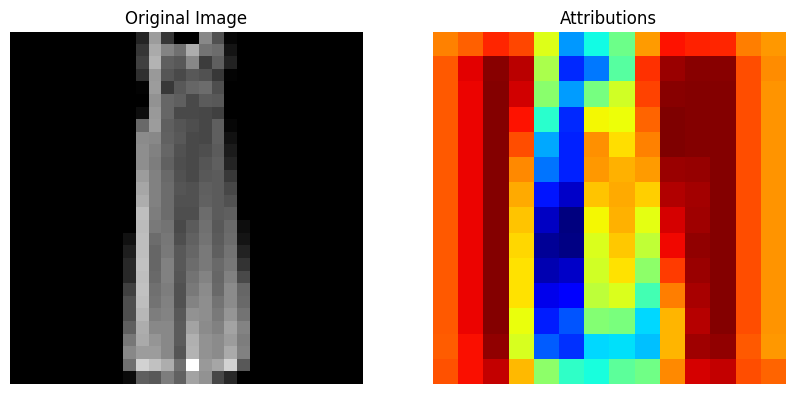

In [18]:
# Plot the original image and its attributions
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_np, cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")
axs[1].imshow(attributions_np, cmap="jet")
axs[1].set_title("Attributions")
axs[1].axis("off")

plt.show()



Top Pixels:
Pixel 11: Average Attribution = -0.0030003658030182123
Pixel 2: Average Attribution = -0.003000366035848856
Pixel 10: Average Attribution = -0.00653042271733284
Pixel 1: Average Attribution = -0.0259954072535038
Pixel 9: Average Attribution = -0.028773197904229164
Pixel 12: Average Attribution = -0.04737020283937454
Pixel 0: Average Attribution = -0.049802105873823166
Pixel 3: Average Attribution = -0.06522443145513535
Pixel 13: Average Attribution = -0.06563969701528549
Pixel 8: Average Attribution = -0.10200734436511993


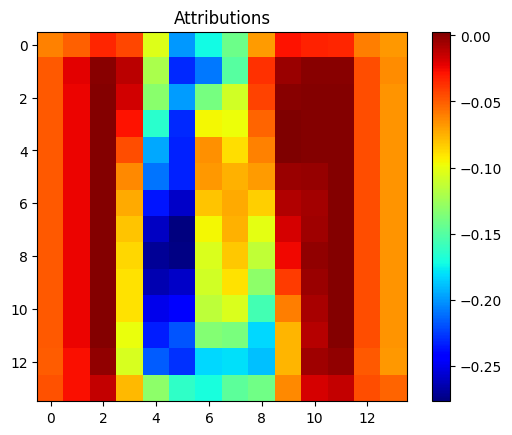

(array([-0.04980211, -0.02599541, -0.00300037, -0.06522443, -0.19930092,
        -0.23177274, -0.1244527 , -0.11081383, -0.10200734, -0.0287732 ,
        -0.00653042, -0.00300037, -0.0473702 , -0.0656397 ], dtype=float32),
 array([11,  2, 10,  1,  9, 12,  0,  3, 13,  8]))

In [19]:
# Analyze the xAI results and gain insights
analyze_xai_results(attributions_np)

In [20]:
# Define the threshold for identifying problematic images
threshold = 0.5

# Define the is_problematic function with your own logic
def is_problematic(image, attribution):
    # Calculate the average attribution score for the image
    avg_attribution = np.mean(attribution)

    # Return True if the average attribution score is below the threshold
    return avg_attribution < threshold





In [21]:
# Modify the dataset based on the xAI analysis (Example: removing problematic images)
modified_train_images = []  # Modify the train_images based on the analysis
modified_train_labels = []  # Modify the train_labels accordingly

for i in range(len(train_images)):
    # Add your modification logic based on the xAI analysis
    # Example: Check if the attribution array has valid dimensions
    if i >= len(attributions_np):
        print(f"Error: Attribution for image {i} is missing.")
        continue

    # Example: Remove images identified as problematic
    if not is_problematic(train_images[i], attributions_np[i]):
        modified_train_images.append(train_images[i])
        modified_train_labels.append(train_labels[i])


Streaming output truncated to the last 5000 lines.
Error: Attribution for image 55000 is missing.
Error: Attribution for image 55001 is missing.
Error: Attribution for image 55002 is missing.
Error: Attribution for image 55003 is missing.
Error: Attribution for image 55004 is missing.
Error: Attribution for image 55005 is missing.
Error: Attribution for image 55006 is missing.
Error: Attribution for image 55007 is missing.
Error: Attribution for image 55008 is missing.
Error: Attribution for image 55009 is missing.
Error: Attribution for image 55010 is missing.
Error: Attribution for image 55011 is missing.
Error: Attribution for image 55012 is missing.
Error: Attribution for image 55013 is missing.
Error: Attribution for image 55014 is missing.
Error: Attribution for image 55015 is missing.
Error: Attribution for image 55016 is missing.
Error: Attribution for image 55017 is missing.
Error: Attribution for image 55018 is missing.
Error: Attribution for image 55019 is missing.
Error: At

In [22]:
# Modify the dataset based on the xAI analysis (Example: removing problematic images)
modified_train_images = []  # Modify the train_images based on the analysis
modified_train_labels = []  # Modify the train_labels accordingly

for i in range(len(train_images)):
    # Add your modification logic based on the xAI analysis
    # Example: Remove images identified as problematic
    if not is_problematic(train_images[i], attributions_np[i]):
        modified_train_images.append(train_images[i])
        modified_train_labels.append(train_labels[i])

IndexError: ignored